In [2]:
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_csv_paths = list(glob(os.path.join('.', 'train_*.csv')))
valid_csv_paths = list(glob(os.path.join('.', 'valid_*.csv')))
assert len(train_csv_paths) > 0

In [3]:
df = pd.read_csv(train_csv_paths[0])

In [4]:
new_columns = {col: col.replace('validation__', '') for col in df.columns if col.startswith('validation__')}
df = df.rename(columns=new_columns)

In [5]:
unweighted_sample_cols = [
    str(col) for col in df.columns if 'unweigted_sample_loss' in col
]

In [46]:
epochs = sorted(list(set(df.epoch_id)))
epochs

[0, 1, 2, 3, 4, 5, 6, 7]

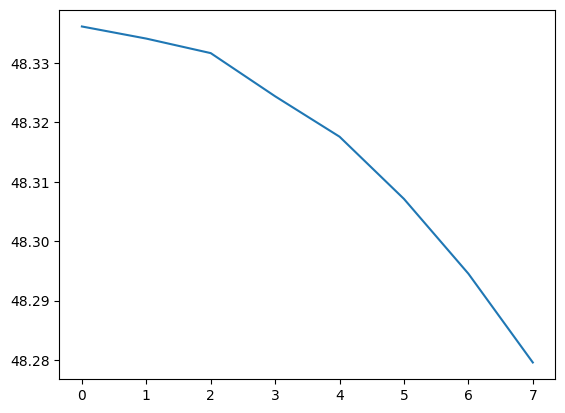

In [47]:
unweighted_losses = []
for i in epochs:
    loss = df.loc[df.epoch_id == i].iloc[:, df.columns.isin(unweighted_sample_cols)].sum(axis=1).mean()
    unweighted_losses.append(loss)
plt.plot(unweighted_losses)

<Figure size 640x480 with 0 Axes>

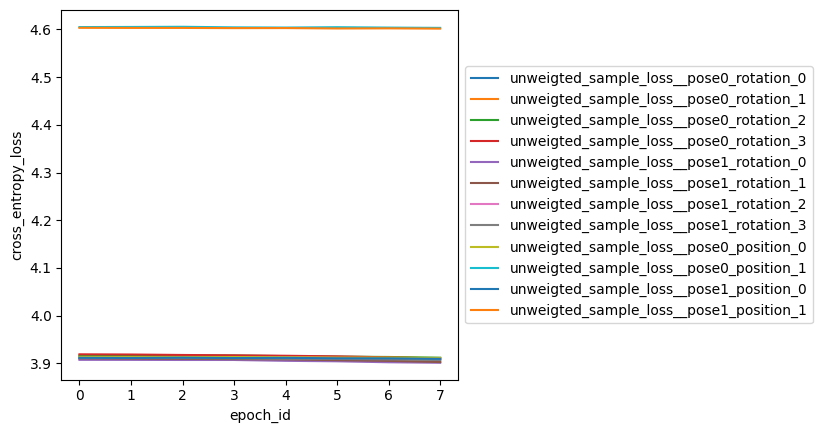

In [48]:
cols = list(df.columns)
rotation_cols = list(col for col in cols if '_rotation_' in col and 'sample_loss' in col)
position_cols = list(col for col in cols if '_position_' in col and 'sample_loss' in col)
fig = plt.figure()
mean_loss = df[rotation_cols + position_cols + ['epoch_id']].groupby('epoch_id').mean()
ax = mean_loss.plot(ylabel='cross_entropy_loss')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [49]:
per_task_loss = df[rotation_cols + position_cols + ['task']].groupby('task').sum().sum(axis=1).sort_values()
per_task_loss / per_task_loss.min()

task
novel_noun                    1.000000
sweep_without_exceeding       2.997638
visual_manipulation           2.998446
rotate                        2.998690
twist                         2.998754
rearrange                     2.999108
follow_order                  2.999192
rearrange_then_restore        2.999215
manipulate_old_neighbor       2.999313
scene_understanding           4.998000
pick_in_order_then_restore    6.000173
dtype: float64

Learning Rate

In [63]:
import math 
from playground.typing import TrainParam, DatasetParam

def get_lr_param():
    return {
        "warmup_end_at_iters": 7000,
        "flatten_end_at_iters": 24000,
        "lr_decay_end_at_iters": 97500,
        "learning_rate": 1e-4,
        "min_lr": 1e-7, 
    }


def get_optimizer_param():
    return {
        "clip_norm": 1.0,
        "inital_lr": get_lr_param()["learning_rate"],
        "optimizer_name": "AdamW",
        "weight_decay": 0.0
    }

def get_dataset_param():
    return  {
        "data_pct_usage": 0.80,
        "total_data_size_per_task": 40000,
        "validation_pct": 0.01,
        "source": "s3://vima",
        "tasks": [
            "follow_order",
            "manipulate_old_neighbor",
            "novel_adj",
            "novel_noun",
            "pick_in_order_then_restore",
            "rearrange_then_restore",
            "rearrange",
            "rotate",
            "same_profile",
            "scene_understanding",
            "simple_manipulation",
            "sweep_without_exceeding",
            "twist",
        ]
    }

def get_train_param():
    return {
        "model_size": "2M",
        "total_epoch": 30,
        "local_batch_size": 128,
        "distributed": False,
    }
def get_lr(it: int) -> float:
    lr_param = get_lr_param()
    warmup_iters = lr_param["warmup_end_at_iters"]
    flatten_iters = lr_param["flatten_end_at_iters"]
    learning_rate = lr_param["learning_rate"]
    lr_decay_iters = lr_param["lr_decay_end_at_iters"]
    min_lr = lr_param["min_lr"]
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if warmup_iters <= it < flatten_iters:
        return learning_rate
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - flatten_iters) / (lr_decay_iters - flatten_iters)
    assert 0 <= decay_ratio <= 1, f"{decay_ratio = }, {it = }"
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)


def get_batch_per_epoch(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        is_train: bool = True
    ):
    if is_train:
        scaling = 1.0
    else:
        scaling = dataset_param["validation_pct"]
    epoch_size = ( 
        int(
            dataset_param["total_data_size_per_task"] 
            * scaling 
            * len(dataset_param["tasks"]
        ) 
        * dataset_param["data_pct_usage"]) 
    )
    batch_size = (
        train_param["local_batch_size"] 
            if train_param["distributed"] is False 
            else train_param["local_batch_size"] * 1
    )
    if epoch_size % batch_size != 0:
        return epoch_size // batch_size + 1
    return epoch_size // batch_size

def get_total_batch_count(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int,
        is_train: bool = True
    ) -> int:
    batch_count_per_epoch = get_batch_per_epoch(dataset_param, train_param, is_train)
    current_total_batch_count = batch_id + epoch_id * batch_count_per_epoch
    return current_total_batch_count

def measure_lr(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int
    ):
    current_total_batch_count = get_total_batch_count(
        dataset_param, 
        train_param, 
        batch_id, 
        epoch_id, 
        is_train=True
    )
    return get_lr(current_total_batch_count)

In [64]:
def get_lrs():
    lrs = []
    for epoch_id in range(get_train_param()["total_epoch"]):
        for batch_id in range(
            get_batch_per_epoch(
                get_dataset_param(),
                get_train_param(),
            )
        ):
            lrs.append(
                measure_lr(
                    get_dataset_param(),
                    get_train_param(),
                    batch_id,
                    epoch_id
                )
            )
    return lrs

65000


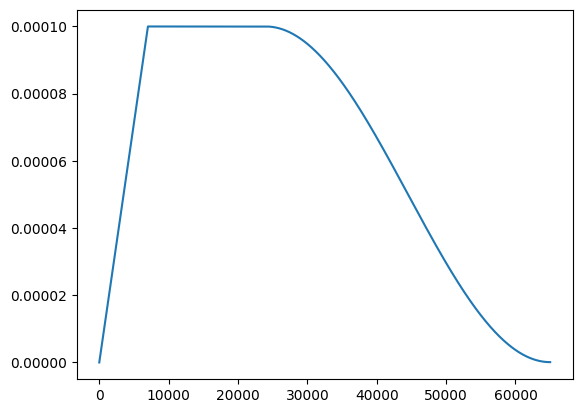

In [65]:
lrs = get_lrs()
print(len(lrs))
_ = plt.plot(lrs)

Eval Result

In [132]:
df = pd.read_csv('eval_2M_offical_release.csv')

In [125]:
task_ids = {
    "visual_manipulation": "01",
    "scene_understanding": "02",
    "rotate": "03",
    "rearrange": "04",
    "rearrange_then_restore": "05",
    "novel_adj": "06",
    "novel_noun": "07",
    "novel_adj_and_noun": "08",
    "twist": "09",
    "follow_motion": "10",
    "follow_order": "11",
    "sweep_without_exceeding": "12",
    "sweep_without_touching": "13",
    "same_texture": "14",
    "same_shape": "15",
    "manipulate_old_neighbor": "16",
    "pick_in_order_then_restore": "17"
}

In [133]:


eval_success_rates = {
    task_ids[group.iloc[0]['task']]: round(float(group[['sucess']].mean().iloc[0] * 100), 1)
        for _, group in df.groupby('task')
}

In [134]:
sorted(list(eval_success_rates.items()))

[('01', 100.0),
 ('02', 100.0),
 ('03', 100.0),
 ('04', 73.0),
 ('05', 18.0),
 ('06', 99.0),
 ('07', 100.0),
 ('09', 20.0),
 ('11', 87.0),
 ('12', 83.0),
 ('15', 95.0),
 ('16', 44.0),
 ('17', 72.0)]

In [31]:
sorted(list(eval_success_rates.items()))

[('01', 66.0),
 ('02', 67.0),
 ('03', 43.0),
 ('04', 47.0),
 ('05', 9.0),
 ('06', 52.0),
 ('07', 67.0),
 ('09', 2.0),
 ('11', 50.0),
 ('12', 69.0),
 ('16', 50.0),
 ('17', 2.0)]

Evalution

In [146]:
import pandas as pd
import glob


mode = 'train'
file_pattern = f'offical\\{mode}_*.csv'
csv_files = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in csv_files]
solution_df = pd.concat(dataframes, ignore_index=True)

In [108]:
loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
position_loss_cols = [col for col in loss_cols if 'position' in col]
rotation_loss_cols = [col for col in loss_cols if 'rotation' in col]

In [109]:
rename = {
    old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
        for old_col_name in loss_cols
}
df[loss_cols].rename(columns=rename).describe()

,pose0_position_0,pose0_position_1,pose1_position_0,pose1_position_1,pose0_rotation_0,pose0_rotation_1,pose0_rotation_2,pose0_rotation_3,pose1_rotation_0,pose1_rotation_1,pose1_rotation_2,pose1_rotation_3
count,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000,416000.000000
mean,3.581519,4.324766,3.341219,4.055724,0.081942,0.078676,0.081090,0.080982,0.080755,0.081267,0.303689,0.303027
std,0.456629,0.459320,0.661268,1.056947,0.515156,0.504191,0.513204,0.513551,0.512096,0.513516,0.784661,0.782397
min,1.394135,2.189099,0.867645,0.000149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.374949,4.155734,3.087518,4.077948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.589095,4.441470,3.437860,4.378124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.831792,4.596246,3.774572,4.578158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.655295,10.248158,10.201399,19.610195,3.911036,3.925617,3.914216,3.921874,3.922834,3.912254,7.271182,7.498718


In [40]:
for task_name, task_df in df[position_loss_cols + ['task']].groupby('task'):
    rename = {
        old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
            for old_col_name in position_loss_cols
    }
    print(task_name)
    print(task_df[position_loss_cols].rename(columns=rename).describe())
    print("=============")

follow_order
       pose0_position_0  pose0_position_1  pose1_position_0  pose1_position_1
count      39600.000000      39600.000000      39600.000000      39600.000000
mean           2.184892          2.435921          2.186342          2.405530
std            0.358844          0.642962          0.349396          0.531122
min            1.282155          1.740094          1.121479          1.771923
25%            1.964048          2.159784          1.975659          2.170060
50%            2.129958          2.282745          2.136747          2.274224
75%            2.336424          2.458995          2.318852          2.437499
max            6.198943         10.811281          5.911872          7.926227
manipulate_old_neighbor
       pose0_position_0  pose0_position_1  pose1_position_0  pose1_position_1
count      39600.000000      39600.000000      39600.000000      39600.000000
mean           2.692819          2.590846          2.267004          2.331384
std            0.507443    

In [111]:
df['sum_loss'] = df[position_loss_cols].sum(axis=1)
df.groupby('task')['sum_loss'].describe().T.columns

Index(['follow_order', 'manipulate_old_neighbor', 'novel_adj', 'novel_noun',
       'pick_in_order_then_restore', 'rearrange', 'rearrange_then_restore',
       'rotate', 'same_profile', 'scene_understanding', 'simple_manipulation',
       'sweep_without_exceeding', 'twist'],
      dtype='object', name='task')

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
follow_order,64000.0,12.367629,1.923127,8.811499,10.906958,11.750578,13.557692,22.908537
manipulate_old_neighbor,64000.0,11.724129,2.198364,8.037513,9.995610,11.008106,13.069666,21.900275
novel_adj,64000.0,13.992611,2.395888,8.527375,11.647576,14.890056,16.038445,42.210238
novel_noun,64000.0,13.950840,2.510707,8.511041,11.518383,14.913919,16.048706,61.063669
pick_in_order_then_restore,64000.0,12.696682,2.411028,8.943959,10.521038,12.241561,15.219339,20.413815
rearrange,64000.0,15.122094,1.468485,10.995800,13.810367,15.483446,16.278308,41.850245
rearrange_then_restore,64000.0,15.340101,1.213808,11.906356,14.282404,15.600585,16.285765,23.063137
rotate,64000.0,15.006868,1.828958,9.468281,13.545364,15.273280,16.298455,49.740836
same_profile,64000.0,13.974323,2.557128,8.769089,11.448327,14.981510,16.318807,30.556741


In [34]:
import pandas as pd
import glob
import os
from typing import List, Literal, Callable

In [1]:

mode = 'train'
i = 0
    
file_pattern = f'logs/{mode}_{i}_*.csv'
csv_files = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dataframes, ignore_index=True)

In [2]:
loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
position_loss_cols = [col for col in loss_cols if 'position' in col]
rotation_loss_cols = [col for col in loss_cols if 'rotation' in col]

In [8]:
rename = {
    old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
        for old_col_name in loss_cols
}
df[loss_cols].rename(columns=rename).describe().columns

Index(['pose0_position_0', 'pose0_position_1', 'pose1_position_0',
       'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
       'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
       'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'],
      dtype='object')

In [59]:
exps = set(
    [
        str(os.path.basename(file_path))
        .split('.')[0]
        .split('_')[2] 
            for file_path in glob.glob('logs/*.csv')
    ]
)

In [80]:
def get_trace_paths(
        exp_id: str, 
        mode: str
    ):
    return [
        exp
            for exp in sorted(
                glob.glob(f'logs/{mode}_*_{exp_id}.csv'),
                key = lambda x: int(x.split('_')[1])
            )
    ]

def trace_epoch(
        exp_id: str, 
        mode: str = 'train'
    ) -> List[pd.DataFrame]:
    return [
        pd.read_csv(exp)
            for exp in 
                get_trace_paths(exp_id, mode)
    ]

def trace_ddp(exp_ids: List[str], epoch: int, mode: str = 'train') -> pd.DataFrame:
    exp_paths = [
        os.path.join('logs', f'{mode}_{epoch}_{exp_id}.csv') for exp_id in exp_ids
    ]
    exp_paths = filter(lambda x: os.path.exists(x), exp_paths)
    dataframes = [
        pd.read_csv(exp_path) for exp_path in exp_paths
    ]
    df = pd.concat(dataframes, ignore_index=True)
    return df


In [82]:
dfs = [
    trace_ddp(exps, i, 'train') for i in range(20)
]

In [139]:
Aggregator = Literal['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
Transform = Callable[[pd.DataFrame], pd.DataFrame]
def measure(
        df: pd.DataFrame, 
        transform: Transform, 
        attr: str, 
        aggr: Aggregator
    ) -> float:
    df = transform(df)
    describe = df.describe()
    if attr not in describe.columns:
        describe = describe.T
    return describe[attr][aggr]
    

In [116]:
attributes = [
    'pose0_position_0', 'pose0_position_1', 'pose1_position_0',
    'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
    'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
    'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'
]
tasks = [
    'follow_order', 'manipulate_old_neighbor', 'novel_adj', 'novel_noun',
    'pick_in_order_then_restore', 'rearrange', 'rearrange_then_restore',
    'rotate', 'same_profile', 'scene_understanding', 'simple_manipulation',
    'sweep_without_exceeding', 'twist'
]

In [86]:
def per_attr_transform(df: pd.DataFrame) -> pd.DataFrame:
    loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
    rename = {
        old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
            for old_col_name in loss_cols
    }
    return df[loss_cols].rename(columns=rename)

In [105]:
measure(solution_df, per_attr_transform, 'pose0_position_0', 'mean')

2.468831945625987

In [145]:
for attr in attributes:
    print(attr, measure(solution_df, per_attr_transform, attr, 'mean'))

pose0_position_0 2.61885160983438
pose0_position_1 3.610646181258731
pose1_position_0 2.412056081458284
pose1_position_1 3.0164096096898323
pose0_rotation_0 1.7766753265172714e-11
pose0_rotation_1 1.1462426375584956e-11
pose0_rotation_2 2.177861038518905e-11
pose0_rotation_3 3.4387290963440347e-12
pose1_rotation_0 1.0459466122274382e-11
pose1_rotation_1 5.158092790498341e-12
pose1_rotation_2 0.11300797151004056
pose1_rotation_3 0.11306070604917735


In [120]:
def per_task_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
    df['sum_loss'] = df[loss_cols].sum(axis=1)
    return df.groupby('task')['sum_loss']

In [147]:

for task in attributes:
    print(task, measure(
        solution_df.loc[
            (solution_df['unweigted_sample_loss__pose0_position_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_position_1'] < 4.6) &
            (solution_df['unweigted_sample_loss__pose1_position_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_position_1'] < 4.6) &
            (solution_df['unweigted_sample_loss__pose0_rotation_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_1'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_2'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_3'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_1'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_2'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_3'] < 3.9) 
        ], 
        per_attr_transform, 
        task, 
        'mean'))

pose0_position_0 2.3030010903788063
pose0_position_1 2.4441153570115057
pose1_position_0 2.2309796770919528
pose1_position_1 2.4016979815139345
pose0_rotation_0 3.662909927242606e-09
pose0_rotation_1 3.408009058173982e-09
pose0_rotation_2 4.259545772983051e-09
pose0_rotation_3 7.106677174605298e-09
pose1_rotation_0 5.9298158385113216e-09
pose1_rotation_1 3.6051467647823192e-09
pose1_rotation_2 0.09609985256525548
pose1_rotation_3 0.09600701260309745


In [91]:
measure(solution_df, per_task_transform, 'follow_order', 'mean')

9.306832213030928

In [83]:
follow_order = [measure(df, per_task_transform, 'follow_order', 'mean') for df in dfs]
follow_order

[13.614772637540474,
 11.59152596796304,
 11.47878340817988,
 11.44872294253111,
 11.436774366147816,
 11.427915397897364,
 11.420311566274613,
 11.407989791359752,
 11.390732829518615,
 11.370667061723768,
 11.34328213886544,
 11.32337905042991,
 11.30055359986797,
 11.275841467015445,
 11.249632636107505,
 11.220619042281061,
 11.152810641900567,
 11.082779925227165,
 11.061323422722518,
 11.056105973258614]